# Librerías 

In [2]:
#Librerías
from pyproj import Transformer
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio.plot import show
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import seaborn as sns
import pandas as pd

# Funciones

In [4]:
import rasterio
from rasterio.mask import mask

# Polígono en WGS84 (MISMA PROYECCIÓN QUE EL DEM)
coords_wgs84 = [
    (-75.4090, 6.1160),
    (-75.3490, 6.1160),
    (-75.3490, 6.1760),
    (-75.4090, 6.1760),
    (-75.4090, 6.1160)
]

polygon = {
    "type": "Polygon",
    "coordinates": [coords_wgs84]
}

with rasterio.open("ASTGTMV003_N06W076_dem.TIF") as src:
    out_image, out_transform = mask(src, [polygon], crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

with rasterio.open("DEM_recortada.tif", "w", **out_meta) as dst:
    dst.write(out_image)

print("Recorte completado correctamente.")


#

Recorte completado correctamente.


DEM reducido: 217 217
Transform: | 0.00, 0.00,-75.41|
| 0.00,-0.00, 6.18|
| 0.00, 0.00, 1.00|
R_max = 12410.736719168981
ideal grid shape: (217, 217, 4)


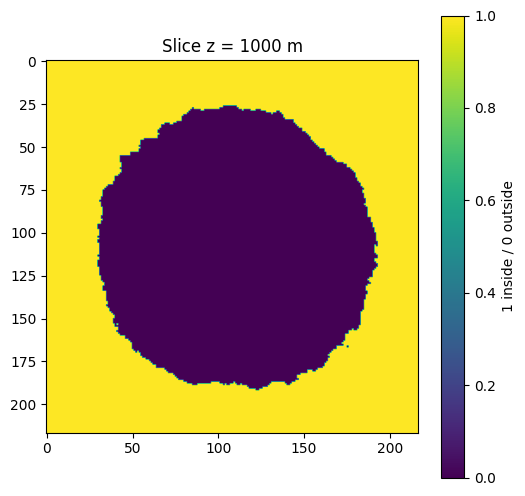

In [21]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from math import cos, radians

# =====================================================
# PARÁMETROS DEL RADAR
# =====================================================
radar_lat = 6.1460       # centrado en el recorte
radar_lon = -75.3790
radar_z = dem.mean()           # altura radar (ajusta si quieres)

Pt = 50000
G = 10
freq = 1e9
lamb = 3e8 / freq
sigma = 10
Bn = 1e6
Fn = 3
SNR_min = 20
theta_half_power = np.deg2rad(30)

# Volumen vertical
z_max = 2000
dz = 500
z_axis = np.arange(0, z_max, dz)
Nz = len(z_axis)

dem_path = "DEM_recortada.tif"

# =====================================================
# FUNCIONES
# =====================================================
def radar_max_range(Pt, G, lamb, sigma, Bn, Fn, SNR_min):
    k = 1.380649e-23
    T0 = 290
    S_min = k * T0 * Bn * Fn * (10**(SNR_min/10))
    Rmax = ((Pt * G**2 * lamb**2 * sigma) / (((4*np.pi)**2) * S_min))**0.25
    return Rmax

def deg_to_m_factors(lat):
    """Conversion de grados a metros localmente."""
    m_per_deg_lat = 111320
    m_per_deg_lon = 111320 * cos(radians(lat))
    return m_per_deg_lat, m_per_deg_lon

# =====================================================
# 1) LEER EL DEM RECORTADO
# =====================================================
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(np.float32)
    transform = src.transform

Nx, Ny = dem.shape
print("DEM reducido:", Nx, Ny)
print("Transform:", transform)

# =====================================================
# 2) GENERAR COORDENADAS (LON, LAT)
# =====================================================
lon0 = transform[2]
lat0 = transform[5]
d_lon = transform[0]
d_lat = transform[4]

lon_vals = lon0 + np.arange(Ny) * d_lon
lat_vals = lat0 + np.arange(Nx) * d_lat

LON, LAT = np.meshgrid(lon_vals, lat_vals)

# =====================================================
# 3) CONVERTIR A METROS
# =====================================================
m_per_deg_lat, m_per_deg_lon = deg_to_m_factors(radar_lat)

dx = (LON - radar_lon) * m_per_deg_lon
dy = (LAT - radar_lat) * m_per_deg_lat

Rxy = np.sqrt(dx**2 + dy**2)

# =====================================================
# 4) EXPANDIR A 3D
# =====================================================
terrain3d = dem[:, :, None] + z_axis[None, None, :]
dz_m = terrain3d - radar_z

theta = np.arctan2(dz_m, Rxy[:, :, None])

# =====================================================
# 5) COMPUTAR R_θ Y R3D
# =====================================================
R_max = radar_max_range(Pt, G, lamb, sigma, Bn, Fn, SNR_min)
print("R_max =", R_max)

R_theta = R_max * np.exp(-2.8 * (theta**2) / (theta_half_power**2))

R_3D = np.sqrt(Rxy[:, :, None]**2 + dz_m**2)

# =====================================================
# 6) IDEAL GRID
# =====================================================
ideal = (R_3D <= R_theta).astype(np.uint8)
print("ideal grid shape:", ideal.shape)

np.save("ideal_grid.npy", ideal)

# =====================================================
# 7) VISUALIZAR
# =====================================================
slice_mid = Nz//2

plt.figure(figsize=(6,6))
plt.imshow(ideal[:, :, slice_mid], cmap='viridis')
plt.colorbar(label="1 inside / 0 outside")
plt.title(f"Slice z = {z_axis[slice_mid]} m")
plt.show()


Grid (rows,cols,Nz): 217 217 4
Pixel size (m): 30.74449085726428 30.922222222226992
Radar height (m): 2095.4172
R_max (m): 12410.736719168981
Computando máscara 'actual' (occlusion test)...
Occlusion test completado.


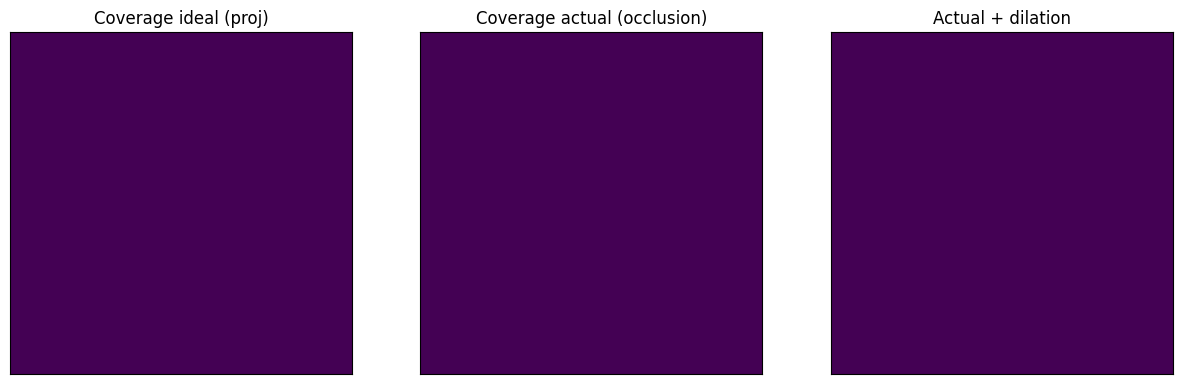

Perfil central (ideal -> actual -> dilated):
ideal: [1 0 0 0]
actual: [1 0 0 0]
dilated: [1 1 0 0]


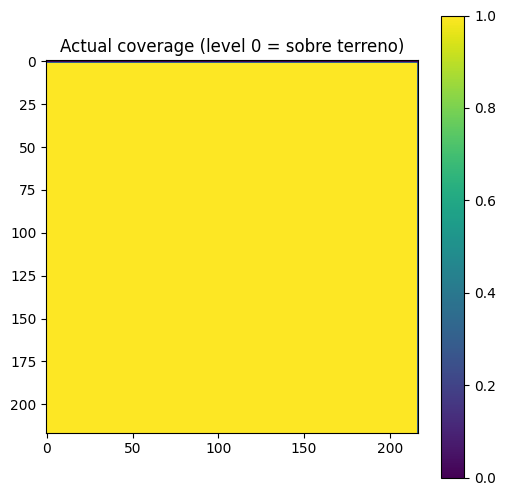

Listo. Archivos guardados: ideal_grid.npy, actual_mask.npy, coverage_2d_*.npy


In [28]:
# ----------- Occlusion test + dilation + proyección 2D ------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# --- Variables que ya debías tener ---
# dem (rows, cols)
# LON, LAT (meshgrid)
# dx, dy (en metros) - matrices same shape as dem
# Rxy, terrain3d, z_axis, ideal, R_3D, R_theta
# radar_lat, radar_lon, radar_z

rows, cols = dem.shape
Nz = len(z_axis)

# Construir x_grid, y_grid en metros relativos al radar (ya calculaste dx,dy arrays)
# Aquí dx,dy variables contienen desplazamientos en metros: dx = (LON - radar_lon)*m_per_deg_lon
x_grid = dx.copy()  # shape (rows, cols)
y_grid = dy.copy()

# pixel sizes en metros (suponemos grilla regular)
pix_x = x_grid[0,1] - x_grid[0,0]   # metros entre columnas
pix_y = y_grid[1,0] - y_grid[0,0]   # metros entre filas (probablemente negativo)
pix_y = abs(pix_y)

# origen top-left en metros (referencia para indices)
x0_m = x_grid[0,0]
y0_m = y_grid[0,0]

# parámetros para muestreo del rayo
min_sample = min(pix_x, pix_y)  # distancia en m entre muestras aproximada
min_sample = max(min_sample, 1.0)  # evitar 0

print("Grid (rows,cols,Nz):", rows, cols, Nz)
print("Pixel size (m):", pix_x, pix_y)
print("Radar height (m):", radar_z)
print("R_max (m):", R_max)

# función de oclusión: retorna actual mask (rows,cols,Nz)
def compute_actual_from_ideal(ideal, dem, x_grid, y_grid, z_axis, radar_z):
    rows, cols, Nz = ideal.shape
    actual = np.zeros_like(ideal, dtype=np.uint8)

    # Precompute for speed
    x0 = x0_m
    y0 = y0_m
    sx = pix_x
    sy = pix_y

    for i in range(rows):
        for j in range(cols):
            vx = x_grid[i, j]
            vy = y_grid[i, j]
            Rxy = np.hypot(vx, vy)
            # skip the radar cell (or extremely close)
            if Rxy < 1e-6:
                # check vertical column directly: if voxel above radar and within R_theta then visible
                for k in range(Nz):
                    if ideal[i,j,k]:
                        actual[i,j,k] = 1
                continue

            # number of samples along the ray based on horizontal distance and sampling step
            # ensure at least a few samples
            steps_base = int(np.ceil(Rxy / min_sample)) + 2

            # Precompute sample fractions (excluding t=0 and t=1)
            t_samples = np.linspace(0.0, 1.0, steps_base)

            for k in range(Nz):
                if ideal[i, j, k] == 0:
                    continue

                voxel_z = dem[i, j] + z_axis[k]
                dz_total = voxel_z - radar_z
                # if voxel is below radar and R_3D <= R_theta we still must check occlusion (ray goes down)
                blocked = False

                # iterate intermediate samples (skip first sample at t=0 which is radar)
                for t in t_samples[1:-1]:
                    xs = vx * t
                    ys = vy * t
                    # distancia horizontal from radar to sample point
                    dist_h = np.hypot(xs, ys)
                    # height of ray at this horizontal distance (linear interpolation)
                    if Rxy == 0:
                        ray_h = radar_z
                    else:
                        ray_h = radar_z + dz_total * (dist_h / Rxy)

                    # map xs, ys back to nearest grid indices
                    col_idx = int(round((xs - x0) / sx))
                    row_idx = int(round((ys - y0) / sy))

                    # If sample outside raster bounds, skip (ray goes outside patch)
                    if row_idx < 0 or row_idx >= rows or col_idx < 0 or col_idx >= cols:
                        continue

                    terrain_h = dem[row_idx, col_idx]

                    # occlusion if terrain higher than ray (allow tiny epsilon)
                    if terrain_h > ray_h + 0.001:
                        blocked = True
                        break

                if not blocked:
                    actual[i, j, k] = 1

    return actual

# Ejecutar la oclusión (tardará algo, pero con 217x217xNz es manejable)
print("Computando máscara 'actual' (occlusion test)...")
actual = compute_actual_from_ideal(ideal, dem, x_grid, y_grid, z_axis, radar_z)
print("Occlusion test completado.")

# Guardar resultado (opcional)
np.save("actual_mask.npy", actual)

# Proyección 2D: cobertura real (si cualquier z visible -> 1)
coverage_2d_actual = (actual.max(axis=2) > 0).astype(np.uint8)
coverage_2d_ideal = (ideal.max(axis=2) > 0).astype(np.uint8)

# DILATACIÓN MORFOLÓGICA 3D (igual que en el artículo — struct element 3x3x3)
struct = np.ones((3,3,3), dtype=bool)
actual_dilated = binary_dilation(actual.astype(bool), structure=struct).astype(np.uint8)

# Proyección 2D luego de dilatación
coverage_2d_dilated = (actual_dilated.max(axis=2) > 0).astype(np.uint8)

# Guardar proyecciones
np.save("coverage_2d_actual.npy", coverage_2d_actual)
np.save("coverage_2d_ideal.npy", coverage_2d_ideal)
np.save("coverage_2d_dilated.npy", coverage_2d_dilated)

# Visualizaciones comparativas
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(coverage_2d_ideal, origin='upper')
axs[0].set_title("Coverage ideal (proj)")
axs[1].imshow(coverage_2d_actual, origin='upper')
axs[1].set_title("Coverage actual (occlusion)")
axs[2].imshow(coverage_2d_dilated, origin='upper')
axs[2].set_title("Actual + dilation")
for ax in axs:
    ax.set_xticks([]); ax.set_yticks([])
plt.show()

# Para inspección: mostrar perfil vertical para un punto cercano y otro lejano
center_i = rows//2
center_j = cols//2
print("Perfil central (ideal -> actual -> dilated):")
print("ideal:", ideal[center_i, center_j, :])
print("actual:", actual[center_i, center_j, :])
print("dilated:", actual_dilated[center_i, center_j, :])

# Slice de ejemplo del nivel 0 (sobre terreno)
plt.figure(figsize=(6,6))
plt.title("Actual coverage (level 0 = sobre terreno)")
plt.imshow(actual[:,:,0], origin='upper')
plt.colorbar()
plt.show()

print("Listo. Archivos guardados: ideal_grid.npy, actual_mask.npy, coverage_2d_*.npy")
